In [1]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper

# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_data
from torch.utils.data import ConcatDataset

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.fitters.p_unet_fitter import PUNetLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.journal_run.model_load.load_ssn import load_ssn
from trustworthai.journal_run.model_load.load_punet import load_p_unet
from trustworthai.journal_run.model_load.load_deterministic import load_deterministic
from trustworthai.journal_run.model_load.load_evidential import load_evidential
from trustworthai.models.stochastic_wrappers.ssn.LowRankMVCustom import LowRankMultivariateNormalCustom
from trustworthai.models.stochastic_wrappers.ssn.ReshapedDistribution import ReshapedDistribution

from trustworthai.utils.losses_and_metrics.evidential_bayes_risks import softplus_evidence, get_alpha, get_S, get_mean_p_hat

# optimizer and lr scheduler
import torch


import numpy as np
import scipy.stats
from trustworthai.utils.plotting.saving_plots import save, imsave
from trustworthai.utils.print_and_write_func import print_and_write

# misc
import argparse
import os
import shutil
import shlex
from collections import defaultdict
from tqdm import tqdm
import sys
from natsort import natsorted

import pandas as pd
from trustworthai.analysis.connected_components.connected_comps_2d import conn_comp_2d_analysis
from trustworthai.analysis.evaluation_metrics.challenge_metrics import getAVD, getDSC, getHausdorff, getLesionDetection, do_challenge_metrics
from sklearn import metrics
import math

import torch
import matplotlib.pyplot as plt
from trustworthai.utils.plotting.saving_plots import save
from trustworthai.utils.print_and_write_func import print_and_write
from trustworthai.analysis.calibration.helper_funcs import *
from tqdm import tqdm
from trustworthai.utils.logits_to_preds import normalize_samples

# evaluation code
from trustworthai.journal_run.evaluation.new_scripts.eval_helper_functions import *
print("banana")


strawberry
banana


In [2]:
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever

In [3]:
import matplotlib.pyplot as plt
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples

In [4]:
%load_ext autoreload

In [5]:
import seaborn as sns

In [6]:
class ARGS():
    def __init__(self):
    
        # folder arguments
        self.ckpt_dir = '/home/s2208943/ipdis/results/journal_models/'#'/media/benp/NVMEspare/model_dump/eval_pl_outdump/'
        self.model_name = "ssn_tune/ssn_prehead32_rank25_sdice0"
        self.model_ckpts_folder = '/home/s2208943/ipdis/results/journal_models/'#"/media/benp/NVMEspare/model_data/journal_models/" # "/home/s2208943/ipdis/results/cross_validated_models/"
        self.repo_dir = '/home/s2208943/ipdis/WMH_UQ_assessment'#"/home/benp/Documents/PhD_projects/WMH_UQ_assessment"
        self.result_dir = "trustworthai/journal_run/evaluation/results/initial_hparam_tuning/in_domain_results"
        self.model_type = "ssn"
        
        # data generation arguments
        self.dataset = 'ed'
        self.seed = 3407
        self.test_split = 0.15
        self.val_split = 0.15
        self.empty_slice_retention = 0.1
        
        # general arguments for the loss function
        self.loss_name = 'dice+xent'#'dicev2'#'dice+xent'
        self.dice_factor = 1#5
        self.xent_factor = 1#0.01
        self.xent_weight = 'none'
        self.xent_reweighting=1
        self.dice_empty_slice_weight = 0.5
        self.tversky_beta = 0.7
        self.reduction = 'mean'#'mean_sum'
        
        # evidential arguments
        self.kl_factor=0.1
        self.kl_anneal_count=452*4
        self.use_mle=0
        self.analytic_kl=0

        # p-unet arguments
        self.kl_beta=10.
        self.use_prior_for_dice="false"
        self.punet_sample_dice_coeff=0.05
        self.latent_dim=12

        # ssn arguments
        self.ssn_rank=25
        self.ssn_epsilon=1e-5
        self.ssn_mc_samples=10
        self.ssn_sample_dice_coeff=0.05
        self.ssn_pre_head_layers=32
        
        # training paradigm arguments
        self.lr = 2e-4
        self.dropout_p = 0.1
        self.encoder_dropout1 = 0
        self.encoder_dropout2 = 0
        self.decoder_dropout1 = 0
        self.decoder_dropout2 = 0
        self.max_epochs = 100
        self.early_stop_patience = 15
        self.batch_size = 8#32
        self.cross_validate = False
        self.cv_split = 0
        self.cv_test_fold_smooth = 1
        self.weight_decay = 0.0001
        self.overwrite = "false"
        self.no_test_fold = 'false'

In [7]:
args = ARGS()
args.overwrite = True if args.overwrite.lower() == "true" else False
args.cross_validate = True

model_ckpts_folder = args.model_ckpts_folder

VOXELS_TO_WMH_RATIO = 382
VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES = 140

# setup xent reweighting factor
XENT_VOXEL_RESCALE = VOXELS_TO_WMH_RATIO - (1-args.empty_slice_retention) * (VOXELS_TO_WMH_RATIO - VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES)

XENT_WEIGHTING = XENT_VOXEL_RESCALE/2
args.xent_reweighting = XENT_WEIGHTING

In [8]:
MODEL_LOADERS = {
    "deterministic":load_deterministic,
    "mc_drop":load_deterministic,
    "evidential":load_evidential,
    "ssn":load_ssn,
    "punet":load_p_unet,
}

In [9]:
def load_best_checkpoint(model, loss, model_ckpt_folder, punet=False):
    # this is ultimately going to need to be passed a model wrapper when I implement P-Unet....
    
    # the path to the best checkpoint is stored as a single line in a txt file along with each model
    with open(os.path.join(model_ckpt_folder, "best_ckpt.txt"), "r") as f:
        ckpt_file = os.path.join(model_ckpt_folder, f.readlines()[0][:-1].split("/")[-1])
    
    if punet:
        return PUNetLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)
    return StandardLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)

In [10]:


def write_model_metric_results(results_file, data):
    for key in data.keys():
        print_and_write(results_file, key, newline=1)
        print_and_write(results_file, data[key])
        
        # ignore any bad images, that will cause values of 0 to appear
        values = data[key]
        ignores = (values < 0.001) | torch.isnan(values)
        if key == 'avd':
            ignores = ignores | (values == 100)
        values = values[~ignores]
        
        print_and_write(results_file, f"{key} mean", newline=1)
        print_and_write(results_file, values.mean())
        
        print_and_write(results_file, f"{key} standard error", newline=1)
        print_and_write(results_file, scipy.stats.sem(values))
        
        
def fast_dice(pred, target):
    p1 = (pred == 1)
    t1 = (target == 1)
    intersection = (pred == 1) & (target == 1)
    numerator = 2 * intersection.sum()
    denominator = p1.sum() + t1.sum()
    return (numerator/(denominator + 1e-30)).item()

def fast_avd(pred, target):
    p1 = pred.sum()
    t1 = target.sum()
    
    return (((p1 - t1).abs() / t1) * 100).item()


def fast_dice(pred, target):
    p1 = (pred == 1)
    t1 = (target == 1)
    intersection = (pred == 1) & (target == 1)
    numerator = 2 * intersection.sum()
    denominator = p1.sum() + t1.sum()
    return (numerator/(denominator + 1e-30)).item()

def fast_vd(pred, target):
    p1 = pred.sum()
    t1 = target.sum()
    
    return (((p1 - t1) / t1) * 100).item()

In [11]:
def GT_volumes(ys3d):
    volumes = []
    for y in ys3d:
        volumes.append(y.sum())
    return torch.Tensor(volumes)

In [12]:
# get the 3d dataloader
data_dict = load_data(
    dataset=args.dataset, 
    test_proportion=args.test_split, 
    validation_proportion=args.val_split,
    seed=args.seed,
    empty_proportion_retained=args.empty_slice_retention,
    batch_size=args.batch_size,
    dataloader2d_only=False,
    cross_validate=args.cross_validate,
    cv_split=args.cv_split,
    cv_test_fold_smooth=args.cv_test_fold_smooth,
    merge_val_test=args.no_test_fold
)


173 35 42


In [13]:
train_imgs = data_dict['train_dataset3d']
val_imgs = data_dict['val_dataset3d']
test_imgs = data_dict['test_dataset3d']

In [14]:
eval_ds = val_imgs

In [15]:
xs3d_test = []
ys3d_test = []

for i, data in enumerate(eval_ds):
    ys3d_test.append(data[1].squeeze())
    xs3d_test.append(data[0])

In [16]:
args.xent_reweighting

82.1

In [17]:
# load the model and loss function
try:
    model_loader = MODEL_LOADERS[args.model_type]
except:
    raise ValueError(f"argument model_type should be one of {MODEL_LOADERS.keys()} not {args.model_type}")
model_raw, loss, val_loss = model_loader(args)

In [18]:
model_dir = os.path.join(args.model_ckpts_folder, args.model_name) 
print("model dir: ", model_dir)
model = load_best_checkpoint(model_raw, loss, model_dir)

model dir:  /home/s2208943/ipdis/results/journal_models/ssn_tune/ssn_prehead32_rank25_sdice0


### generating a bunch of samples

In [19]:
def punet_mean_and_samples(inputs):
    model_raw=inputs['model']
    x=inputs['x']
    y=inputs['y']
    num_samples = inputs['num_samples']
    
    model_raw(x.swapaxes(0,1).cuda(), y.cuda(), training=False)
    mean = model_raw.sample(use_prior_mean=True).cpu()
    
    ind_samples = []
    for j in range(num_samples):
                ind_samples.append(model_raw.sample(testing=False).cpu())

    ind_samples = torch.stack(ind_samples, dim=0)
    
    return mean, ind_samples


def evid_mean(inputs):
    model_raw=inputs['model']
    x=inputs['x']
    y=inputs['y']
    logits = model_raw(x.swapaxes(0,1).cuda()).cpu()
    evidence = softplus_evidence(logits)
    alpha = get_alpha(evidence)
    # print(alpha.shape)
    S = get_S(alpha)
    K = alpha.shape[1]
    mean_p_hat = get_mean_p_hat(alpha, S)
    return mean_p_hat, None

def deterministic_mean(inputs):
    model_raw=inputs['model']
    x=inputs['x']
    y=inputs['y']
    num_samples = inputs['num_samples']
    pass

def ssn_mean_and_samples(inputs):
    model_raw=inputs['model']
    x=inputs['x']
    y=inputs['y']
    num_samples = inputs['num_samples']
    mean, sample = model_raw.mean_and_sample(x.swapaxes(0,1).cuda(), num_samples=num_samples, temperature=1)
    
    return mean, sample

def mc_drop_mean_and_samples(inputs):
    model_raw=inputs['model']
    x=inputs['x']
    y=inputs['y']
    num_samples = inputs['num_samples']
    x = x.swapaxes(0,1).cuda()
    mean = model_raw(x)
    model.train()
    ind_samples = []
    for j in range(num_samples):
        ind_samples.append(model_raw(x))
    model.eval()
    ind_samples = torch.stack(ind_samples, dim=0)
    return mean, ind_samples

def ensemble_mean_and_sample(inputs):
    model_raw=inputs['model']
    x=inputs['x']
    y=inputs['y']
    num_samples = inputs['num_samples']
    pass

def ssn_ensemble_mean_and_sample(inputs):
    model_raw=inputs['model']
    x=inputs['x']
    y=inputs['y']
    num_samples = inputs['num_samples']
    pass

In [20]:
def get_means_and_samples(model_raw, eval_ds, num_samples, model_func, extra_kwargs={}):
    means = []
    samples = []

    model_raw.eval()
    for i, data in enumerate(tqdm(eval_ds, position=0, leave=True)):
        x = data[0]
        y = data[1]
        inputs = {**{"model":model_raw, "x":x, "y":y, "num_samples":num_samples}, **extra_kwargs}
        with torch.no_grad():
            mean, sample = model_func(inputs)
            means.append(mean.cpu())
            samples.append(sample.cpu())
            
    return means, samples



In [21]:
means, samples = get_means_and_samples(model_raw, eval_ds, num_samples=10, model_func=ssn_mean_and_samples)

  0%|                                                                                                                                                                  | 0/35 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:11<00:00,  3.14it/s]


In [22]:
def reorder_samples(sample):
    sample = sample.cuda()
    slice_volumes = sample.argmax(dim=2).sum(dim=(-1, -2))
    slice_volume_orders = torch.sort(slice_volumes.T, dim=1)[1]
    
    # rearrange the samples into one...
    new_sample = torch.zeros(sample.shape).to(sample.device)
    for i, slice_volumes_orders in enumerate(slice_volume_orders):
        for j, sample_index in enumerate(slice_volumes_orders):
            new_sample[j][i] = sample[sample_index][i]
            
    return new_sample.cpu()

In [23]:
samples[0].shape

torch.Size([10, 40, 2, 224, 160])

In [24]:
samples = [reorder_samples(s) for s in samples]

In [25]:
preds = [torch.softmax(m.cuda(), dim=1).cpu() for m in means]

In [26]:
chal_results = per_model_chal_stats(means, ys3d_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:44<00:00,  1.26s/it]


In [27]:
avds = []
for m, y in zip(means, ys3d_test):
    avds.append(fast_avd(m.cuda().argmax(dim=1), y.cuda()))
    
dices = []
for m, y in zip(means, ys3d_test):
    dices.append(fast_dice(m.cuda().argmax(dim=1), y.cuda()))

In [28]:
torch.Tensor(dices).mean()

tensor(0.7391)

In [29]:
len(samples)

35

In [30]:
def per_sample_metric(samples, ys3d_test, f, do_argmax, do_softmax, minimise):
    num_samples = len(samples[0])
    samples_f = []
    for i in tqdm(range(len(ys3d_test)), position=0, leave=True):
        scores = []
        y = ys3d_test[i].cuda()
        for j in range(num_samples):
            if do_argmax:
                s = samples[i][j].cuda().argmax(dim=1)
            elif do_softmax:
                s = torch.softmax(samples[i][j].cuda(), dim=1)
            else:
                s = samples[i][j].cuda()
            scores.append(f(s, y))
        scores = torch.Tensor(scores)
        samples_f.append(scores)

    samples_f = torch.stack(samples_f)

    if minimise:
        return samples_f.min(dim=1)[0], samples_f
    else:
        return samples_f.max(dim=1)[0], samples_f

In [31]:
sample_top_dices, sample_dices = per_sample_metric(samples, ys3d_test, f=fast_dice, do_argmax=True, do_softmax=False, minimise=False)
sample_best_avds, sample_avds = per_sample_metric(samples, ys3d_test, f=fast_avd, do_argmax=True, do_softmax=False, minimise=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 41.36it/s]


In [32]:
def fast_rmse(pred, y, p=0.1):
    locs = (pred[:,1] > p)
    onehot = (y.unsqueeze(dim=1)==y.unique().view(1, -1, 1, 1)).type(torch.float32)
    
    pred = pred.moveaxis(1, -1)[locs]
    onehot = onehot.moveaxis(1, -1)[locs]
    
    return (pred - onehot).square().sum(dim=1).mean().sqrt()

In [33]:
rmses = []
for m, y in zip(means, ys3d_test):
    rmses.append(fast_rmse(m.cuda().softmax(dim=1), y.cuda()).cpu())
rmses = torch.Tensor(rmses)

In [34]:
sample_best_rmses, sample_rmses = per_sample_metric(samples, ys3d_test, f=fast_rmse, do_argmax=False, do_softmax=True, minimise=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 32.69it/s]


In [35]:
sample_best_rmses.mean(), rmses.mean()

(tensor(0.5242), tensor(0.5379))

In [36]:
gt_vols = GT_volumes(ys3d_test)

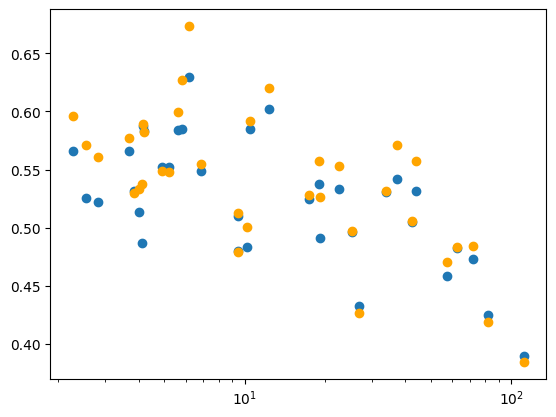

In [37]:
plt.scatter(gt_vols * 0.003, sample_best_rmses)
plt.scatter(gt_vols * 0.003, rmses, c='orange')
plt.xscale('log')

In [38]:
import pandas as pd

In [39]:
chal_results['best_dice'] = sample_top_dices
chal_results['best_avd'] = sample_best_avds
chal_results['rmse'] = rmses
chal_results['best_rmse'] = sample_best_rmses

In [40]:
df = pd.DataFrame(chal_results)
df['model_name'] = [args.model_name for _ in range(len(df))]

In [41]:
df

,dice,hd95,avd,recall,f1,best_dice,best_avd,rmse,best_rmse,model_name
0,0.647578,3.162278,16.986900,0.555556,0.619469,0.649362,4.847161,0.554620,0.548435,ssn_tune/ssn_prehead32_rank25_sdice0
1,0.873671,1.414214,5.954548,0.780000,0.692685,0.877018,1.591346,0.470739,0.458705,ssn_tune/ssn_prehead32_rank25_sdice0
2,0.588161,5.000000,19.248423,0.750000,0.774194,0.587675,2.954676,0.591945,0.584549,ssn_tune/ssn_prehead32_rank25_sdice0
3,0.646564,2.236068,1.553510,0.729167,0.629105,0.636950,12.830840,0.547760,0.551873,ssn_tune/ssn_prehead32_rank25_sdice0
4,0.912884,1.414214,1.481999,0.650000,0.643110,0.909098,2.096128,0.418764,0.425343,ssn_tune/ssn_prehead32_rank25_sdice0
5,0.628240,4.898980,18.048780,0.448980,0.610707,0.642348,6.097561,0.577126,0.566099,ssn_tune/ssn_prehead32_rank25_sdice0
6,0.725482,2.236068,2.412451,0.393939,0.483271,0.720570,14.241245,0.529485,0.531720,ssn_tune/ssn_prehead32_rank25_sdice0
7,0.554024,11.108498,39.392380,0.410256,0.561404,0.624861,1.338826,0.626890,0.584508,ssn_tune/ssn_prehead32_rank25_sdice0
8,0.636974,2.236068,38.293335,0.887500,0.830750,0.654385,3.946667,0.599198,0.584381,ssn_tune/ssn_prehead32_rank25_sdice0
9,0.487484,10.289964,36.069115,0.347222,0.442834,0.489018,3.815695,0.589048,0.587236,ssn_tune/ssn_prehead32_rank25_sdice0


In [42]:
overall_stats = {"model_name":[args.model_name]}

for key, value in chal_results.items():
    mean = value.mean()
    std = value.std(correction=1) # https://en.wikipedia.org/wiki/Bessel%27s_correction#Source_of_bias in this case we know the true mean..?
    # I want the standard deviation across this dataset, and I have a full sample, so I should use correction = 0? Or are we saying we have a limited sample of data from
    # an infinite distribution, and we want to know the model performance on that distribution, so correction = 1. Hmm this is a bit of a headache.
    conf_int = 1.96 * std / np.sqrt(len(value))

    lower_bound = mean - conf_int
    upper_bound = mean + conf_int
    
    overall_stats[f"{key}_mean"] = [mean.item()]
    overall_stats[f"{key}_95%conf"] = [conf_int.item()]

    print(f"95% confidence interval for {key}: [{lower_bound:.3f}, {upper_bound:.3f}], conf_int={conf_int:.3f}")

95% confidence interval for dice: [0.701, 0.777], conf_int=0.038
95% confidence interval for hd95: [2.627, 4.868], conf_int=1.120
95% confidence interval for avd: [11.697, 21.967], conf_int=5.135
95% confidence interval for recall: [0.555, 0.694], conf_int=0.070
95% confidence interval for f1: [0.570, 0.659], conf_int=0.045
95% confidence interval for best_dice: [0.713, 0.785], conf_int=0.036
95% confidence interval for best_avd: [2.710, 4.738], conf_int=1.014
95% confidence interval for rmse: [0.518, 0.558], conf_int=0.020
95% confidence interval for best_rmse: [0.507, 0.542], conf_int=0.017


In [43]:
overall_stats

{'model_name': ['ssn_tune/ssn_prehead32_rank25_sdice0'],
 'dice_mean': [0.7390660047531128],
 'dice_95%conf': [0.038097236305475235],
 'hd95_mean': [3.7473692893981934],
 'hd95_95%conf': [1.120322585105896],
 'avd_mean': [16.831995010375977],
 'avd_95%conf': [5.135120391845703],
 'recall_mean': [0.6244380474090576],
 'recall_95%conf': [0.06957070529460907],
 'f1_mean': [0.6142008304595947],
 'f1_95%conf': [0.0445595309138298],
 'best_dice_mean': [0.7489198446273804],
 'best_dice_95%conf': [0.03575572371482849],
 'best_avd_mean': [3.723839044570923],
 'best_avd_95%conf': [1.0136934518814087],
 'rmse_mean': [0.5379194617271423],
 'rmse_95%conf': [0.019884785637259483],
 'best_rmse_mean': [0.5242250561714172],
 'best_rmse_95%conf': [0.017451206222176552]}

In [44]:
torch.Tensor(dices).mean(), torch.Tensor(avds).mean()

(tensor(0.7391), tensor(16.8320))

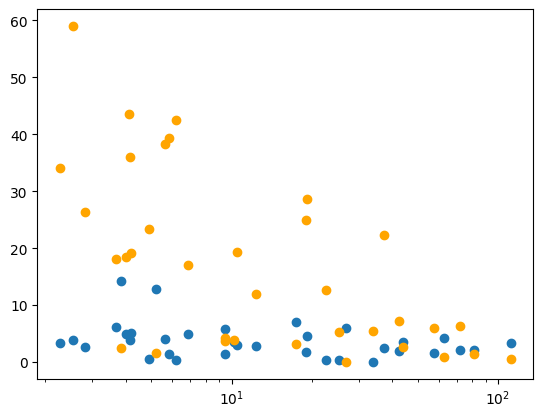

In [45]:
plt.scatter(gt_vols * 0.003, sample_best_avds)
plt.scatter(gt_vols * 0.003, avds, c='orange')
plt.xscale('log')

In [ ]:
samples_f.shape

torch.Size([35, 50])

In [ ]:
len(samples[0])

50

In [ ]:
samples_f.min(dim=1)[0].mean()

tensor(18.5293)

In [119]:
s0sum = samples[0].cuda().argmax(dim=2).view(50, -1).sum(dim=1).cpu()

In [50]:
samples[0].shape

torch.Size([50, 40, 2, 224, 160])

In [51]:
s0sum.min(), s0sum.max()

(tensor(1043), tensor(1168))

In [54]:
new_sample = reorder_samples(samples[0].cuda().argmax(dim=2))

In [57]:
new_sample.view(50, -1).sum(-1).min(), new_sample.view(50, -1).sum(-1).max()

(tensor(736., device='cuda:0'), tensor(1415., device='cuda:0'))

In [2]:
import os

In [4]:
os.listdir("/media/benp/NVMEspare/model_data/journal_models/ssn_tune")

['ssn_prehead16_rank15_sdice0']

In [30]:
model_result_dir = os.path.join(args.repo_dir, args.result_dir, args.model_name)

In [84]:
df.to_csv(model_result_dir + "_individual_stats.csv")
overall_stats.to_csv(model_result_dir + "_overall_stats.csv")

In [82]:
model_result_dir

'/home/benp/Documents/PhD_projects/WMH_UQ_assessment/trustworthai/journal_run/evaluation/results/initial_hparam_tuning/out_domain_results/standard_model_duplicate'

In [ ]:
model_result_dir

In [39]:
import scipy.stats

In [45]:
1.96 * scipy.stats.sem(data['dice'], ddof=1)

0.057390846351506014

In [32]:
################################### The actual run script ##################################
################################### Nice ###################################################


# The only run script that I need for a deterministic model is to find the challenge metrics etc for the model predictions. Nice.


def run_eval(args):
    
    name = args.name
    splits = args.splits
    stride = args.stride
    temp = 1
    num_samples = 10
        
    
    name_to_method_map = {
        "softmax_ent":[generate_means_and_samples_CategoricalSoftmax],
        "mc_drop":[generate_means_and_samples_MC_Dropout],
        "evidential":[generate_means_and_samples_Evidential],
        "ensemble":[generate_means_and_samples_Ensemble],
        "SSN_ensemble":[generate_means_and_samples_SSN_Ens],
        "SSN_ensemble_mean":[generate_means_and_samples_SSN_Ens_Mean],
        "SSN":[generate_means_and_samples_SSN],
        "SSN_Ind":[generate_means_and_samples_SSN],
        "P-Unet":[generate_means_and_samples_PUNet],
    }
    
    method_func = name_to_method_map[name][0]
    if name == "SSN_Ind":
        means, samples, test_datasets = method_func(splits=splits, dataset_stride=stride, temp=temp, num_samples=num_samples, independent=True)
    elif name == "softmax_ent":
        means, samples, test_datasets = method_func(splits=splits, dataset_stride=stride, temp=temp, num_samples=num_samples, loss_name=args.determin_loss_name)
    else:
        means, samples, test_datasets = method_func(splits=splits, dataset_stride=stride, temp=temp, num_samples=num_samples)
        
    if "softmax" in name:
        name += "_" + args.determin_loss_name

    save_folder = f"/home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/results/{name}/"
    results_file = save_folder + "text_results.txt"

    try:
        os.mkdir(save_folder)
        os.mkdir(save_folder + "/images")
    except:
        pass

    with open(results_file, "w") as f:
        print_and_write(results_file, "begin results")
       
    
    # GET THE UMAPS
    # softmax entropy
    if "softmax" in name:
        ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=True) for scan_index in range(len(means))]

    # evidential
    elif "evidential" in name:
        ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=False) for scan_index in range(len(means))]

    else:
        ent_maps = [entropy_map_from_samples(samples[scan_index]) for scan_index in range(len(means))]
      
    
    # collect input data
    xs3d_test = []
    ys3d_test = []

    for i, data in enumerate(test_datasets):
        if i % stride == 0:
            ys3d_test.append(data[1].squeeze())
            xs3d_test.append(data[0])
            
    # do some plotting
    # plot_example(save_folder, test_datasets, means, ent_maps, 87, 15, stride)
    # plot_example(save_folder, test_datasets, means, ent_maps, 103, 35,stride)
    # plot_example(save_folder, test_datasets, means, ent_maps, 52, 35, stride)
    # plot_example(save_folder, test_datasets, means, ent_maps, 1, 25, stride)
    plot_example(save_folder, test_datasets, means, ent_maps, 0, 25, stride)
    # plot_example(save_folder, test_datasets, means, ent_maps, 57, 25, stride)
    # plot_example(save_folder, test_datasets, means, ent_maps, 60, 30, stride)
    # plot_example(save_folder, test_datasets, means, ent_maps, 70, 25, stride)
    
    plt.style.use('fivethirtyeight')
    
    # energy distance score
    geds_reordered = iou_GED(means, ys3d_test, samples, reorder=True)
    
    print_and_write(results_file, "reordered GED values", newline=1)
    print_and_write(results_file, geds_reordered)

    print_and_write(results_file, "reordered GED mean", newline=1)
    print_and_write(results_file, geds_reordered.mean())

    print_and_write(results_file, "reordered GED standard error", newline=1)
    print_and_write(results_file, scipy.stats.sem(geds_reordered))
    
    # sample diversity analysis
    standard_sample_dices = metric_across_samples_analysis(results_file, ys3d_test, samples, reorder=False, metric="dice")
    reorder_sample_dices = metric_across_samples_analysis(results_file, ys3d_test, samples, reorder=True, metric="dice")
    standard_sample_avds = metric_across_samples_analysis(results_file, ys3d_test, samples, reorder=False, metric="avd")
    reorder_sample_avds = metric_across_samples_analysis(results_file, ys3d_test, samples, reorder=True, metric="avd")
    
    # standard_sample_VDS = vd_per_sample(ys3d_test, samples, reorder=False)
    reorder_sample_VDS = vd_per_sample(ys3d_test, samples, reorder=True)
    gt_vols = GT_volumes(ys3d_test)
    sample_diversity_plot_by_volume(save_folder, reorder_sample_VDS*0.003, gt_vols, "Volume Difference (%)")
    
    # bras and sueo scores
    uncertainty_thresholds = torch.arange(0, 0.7, 0.01)

    filtered_dices = []
    filtered_tns = []
    filtered_tps = []

    for i in tqdm(range(len(means)), position=0, leave=True):
        mean = means[i].cuda().argmax(dim=1)
        ent_map = ent_maps[i].cuda()
        y = ys3d_test[i].cuda()
        mask = xs3d_test[i][1].cuda()

        ind_filtered_dices = []
        ind_filtered_tns = []
        ind_filtered_tps = []

        if mean.sum() == 0:
            continue

        for t in uncertainty_thresholds:
            ind_filtered_dices.append(filtered_dice(mean, ent_map, y, t))
            ind_filtered_tns.append(filtered_tns_score(mask, mean, ent_map, y, t))
            ind_filtered_tps.append(filtered_tps_score(mean, ent_map, y, t))

        filtered_dices.append(ind_filtered_dices)
        filtered_tns.append(ind_filtered_tns)
        filtered_tps.append(ind_filtered_tps)


    # we need to calculate the area under the curve of the dice, so that will be mean dice per threshold?
    filtered_dices = torch.stack([torch.Tensor(v) for v in filtered_dices], dim=0)
    filtered_tns = torch.stack([torch.Tensor(v) for v in filtered_tns], dim=0)
    filtered_tps = torch.stack([torch.Tensor(v) for v in filtered_tps], dim=0)
    
    fdice_curve = filtered_dices.mean(dim=0)
    tn_curve = filtered_tns.mean(dim=0)
    tp_curve = filtered_tps.mean(dim=0)
    max_ent = math.log(0.5)
    bras_score = (1/3) * (
        metrics.auc(uncertainty_thresholds/max_ent, fdice_curve)
         + (1 - metrics.auc(uncertainty_thresholds/max_ent, tn_curve))
         + (1 - metrics.auc(uncertainty_thresholds/max_ent, tp_curve))
    )
    print_and_write(results_file, "bras score", newline=1)
    print_and_write(results_file, bras_score)
    
    sUEOs = []
    for i in tqdm(range(len(means)), position=0, leave=True):
        pred = means[i].argmax(dim=1).cuda()
        target = ys3d_test[i].cuda()
        ent = ent_maps[i].cuda()

        if pred.sum() == 0:
            continue

        sUEOs.append(sUEO(pred, ent, target))

    sUEOs = torch.Tensor(sUEOs)
    print_and_write(results_file, "sUEO mean", newline=1)
    print_and_write(results_file, sUEOs.mean())

    print_and_write(results_file, "sUEO standard error", newline=1)
    print_and_write(results_file, scipy.stats.sem(sUEOs))
    
    UEO_per_threshold_analysis(save_folder, results_file, uncertainty_thresholds, ys3d_test, ent_maps, means, max_ent)
    
    if "softmax" in name:
        # for softmax entropy
        calibration_over_samples(save_folder, results_file, means, samples, ys3d_test, do_normalize=True, mode="mean_only")

    # evidential
    elif "evidential" in name:
        # For evidential
        calibration_over_samples(save_folder, results_file, means, samples, ys3d_test, do_normalize=False, mode="mean_only")

    else:
        # for other models
        calibration_over_samples(save_folder, results_file, means, samples, ys3d_test, do_normalize=True, mode="mean_conf")
        
        
    # collect the challenge data
    challenge_data = per_model_chal_stats(means, ys3d_test)
    write_model_metric_results(results_file, challenge_data)
    
    # the more expensive code goes at the end
    # 2D slice coverage
    uncertainty_thresholds = torch.arange(0, 0.7, 0.01)
    conn_comp_2d_analysis(save_folder, results_file, uncertainty_thresholds, ys3d=ys3d_test, means3d=means, ind_ent_maps=ent_maps)
    
    print("DONE!")

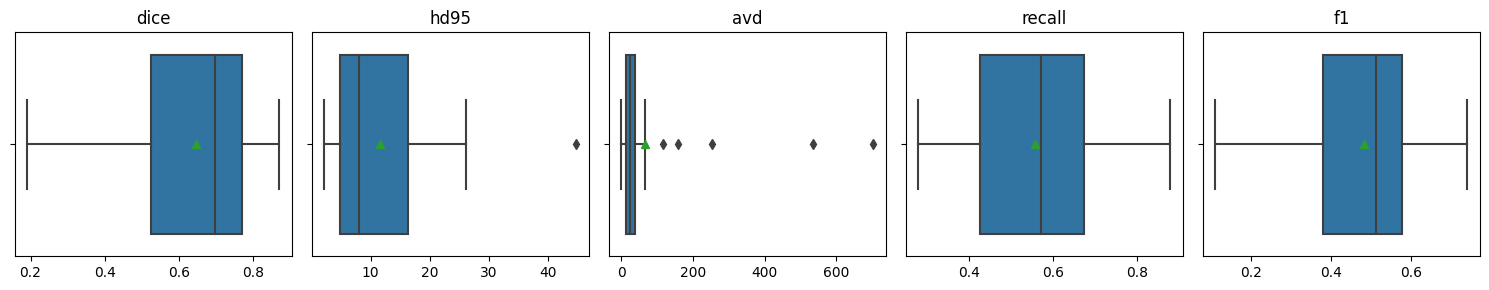

In [30]:
data = chal_results
# Create a figure with subfigures
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the data dictionary and create boxplots for each key
for i, (key, value) in enumerate(data.items()):
    sns.boxplot(
        x=value.tolist(),
        ax=axes[i],
        showmeans=True,
    )

    axes[i].set_title(key)

# Tighten the layout
plt.tight_layout()

# Show the figure
plt.show()